In [1]:
%load_ext autoreload
%autoreload 2
feat_no = 102
is_tfidf = True
is_svd = True
from main_quara import quara_load_data, cleansing_text
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import datetime
import sys
import re
import gc
import glob
import pickle as pkl
import os
HOME = os.path.expanduser('~')
sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
import utils
from utils import logger_func, get_categorical_features, get_numeric_features, pararell_process
logger = logger_func()

from joblib import Parallel, delayed
from contextlib import contextmanager
@contextmanager
def timer(name):
    """
    Taken from Konstantin Lopuhin https://www.kaggle.com/lopuhin
    in script named : Mercari Golf: 0.3875 CV in 75 LOC, 1900 s
    https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
    """
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')
    
key = 'qid'
qt = 'question_text'
target = 'target'

train, test = quara_load_data()

2018-11-22 16:16:08,351 utils 366 [INFO]    [logger_func] start 
100%|██████████| 3/3 [00:00<00:00, 181.19it/s]


In [38]:
from itertools import chain

t0 = train[train[target]==0]
t1 = train[train[target]==1]

t0_words = list(chain.from_iterable([doc.split() for doc in t0[qt].values]))
t1_words = list(chain.from_iterable([doc.split() for doc in t1[qt].values]))

df_0 = pd.DataFrame({'word':t0_words}).groupby('word').size().reset_index().rename(columns={0:'cnt_0'})
df_1 = pd.DataFrame({'word':t1_words}).groupby('word').size().reset_index().rename(columns={0:'cnt_1'})
# 10回以上出現している単語
df_0 = df_0[df_0['cnt_0']>=10]
df_1 = df_1[df_1['cnt_1']>=3]
print(df_0.shape)
print(df_1.shape)
display(df_0.head(10))

(49645, 2)
(24114, 2)


,word,cnt_0
2,!,18
6,"""",481
135,"""2",10
224,"""?",87
235,"""A",215
236,"""A""",17
408,"""All",33
452,"""America",17
456,"""American",28
476,"""An",22


In [39]:
len_t0 = len(t0)
len_t1 = len(t1)
df_0['cnt_0'] /= len_t0
df_1['cnt_1'] /= len_t1

df = df_0.merge(df_1, how='left', on='word' )

df['diff'] = df['cnt_0'] - df['cnt_1']
df.sort_values(by='diff', ascending=False, inplace=True)

display(df.head(15))

,word,cnt_0,cnt_1,diff
15184,What,0.335993,0.075560,0.260433
7468,How,0.207637,0.092934,0.114703
7546,I,0.240775,0.139042,0.101733
18509,best,0.049615,0.007660,0.041955
19836,can,0.097281,0.056020,0.041261
49504,you,0.145078,0.107289,0.037789
15217,Which,0.038198,0.006175,0.032023
30841,in,0.279703,0.252543,0.027160
35336,my,0.081080,0.058334,0.022745
31859,is,0.255323,0.232607,0.022715


In [47]:
# ratio diffをround5で丸め、絶対値でソート。単語数1,000までになるまでカウントし、その閾値を探る.
# 絶対値で0.0012以上のdiffがある単語に絞ると、約1,000単語にできる。
# print(len(diff_5[diff_5>0.0012])) = 997

diff_5 = np.round(np.abs(df['diff'].values), 5)
cnt = 0
val_cnt = pd.Series(diff_5).value_counts().reset_index().sort_values(by='index', ascending=False).reset_index(drop=True)
for i in val_cnt[0]:
    cnt += len(val_cnt[val_cnt[0]==i])
    if cnt>=1000:
        print(val_cnt[val_cnt[0]==i])
        sys.exit()

997
       index  0
0    0.31486  1
1    0.26043  1
2    0.16591  1
3    0.14232  1
4    0.14200  1
5    0.12277  1
6    0.11470  1
7    0.11455  1
8    0.10394  1
9    0.10173  1
10   0.08660  1
11   0.08237  1
12   0.07762  1
13   0.06957  1
14   0.05525  1
15   0.05374  1
16   0.05318  1
17   0.05178  1
18   0.04939  1
19   0.04633  1
20   0.04389  1
21   0.04196  1
22   0.04193  1
23   0.04126  1
24   0.04100  1
25   0.03940  1
26   0.03779  1
27   0.03699  1
28   0.03670  1
29   0.03466  1
..       ... ..
310  0.00309  1
311  0.00308  1
314  0.00304  1
316  0.00302  1
317  0.00301  1
318  0.00298  1
319  0.00297  1
320  0.00296  1
322  0.00294  1
324  0.00292  1
328  0.00287  1
330  0.00285  1
334  0.00279  1
340  0.00270  1
341  0.00269  1
342  0.00268  1
343  0.00267  1
346  0.00260  1
349  0.00257  1
353  0.00253  1
356  0.00250  1
366  0.00233  1
371  0.00226  1
372  0.00225  1
374  0.00222  1
375  0.00221  1
390  0.00206  1
397  0.00199  1
403  0.00193  1
442  0.00153  1

[30

SystemExit: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


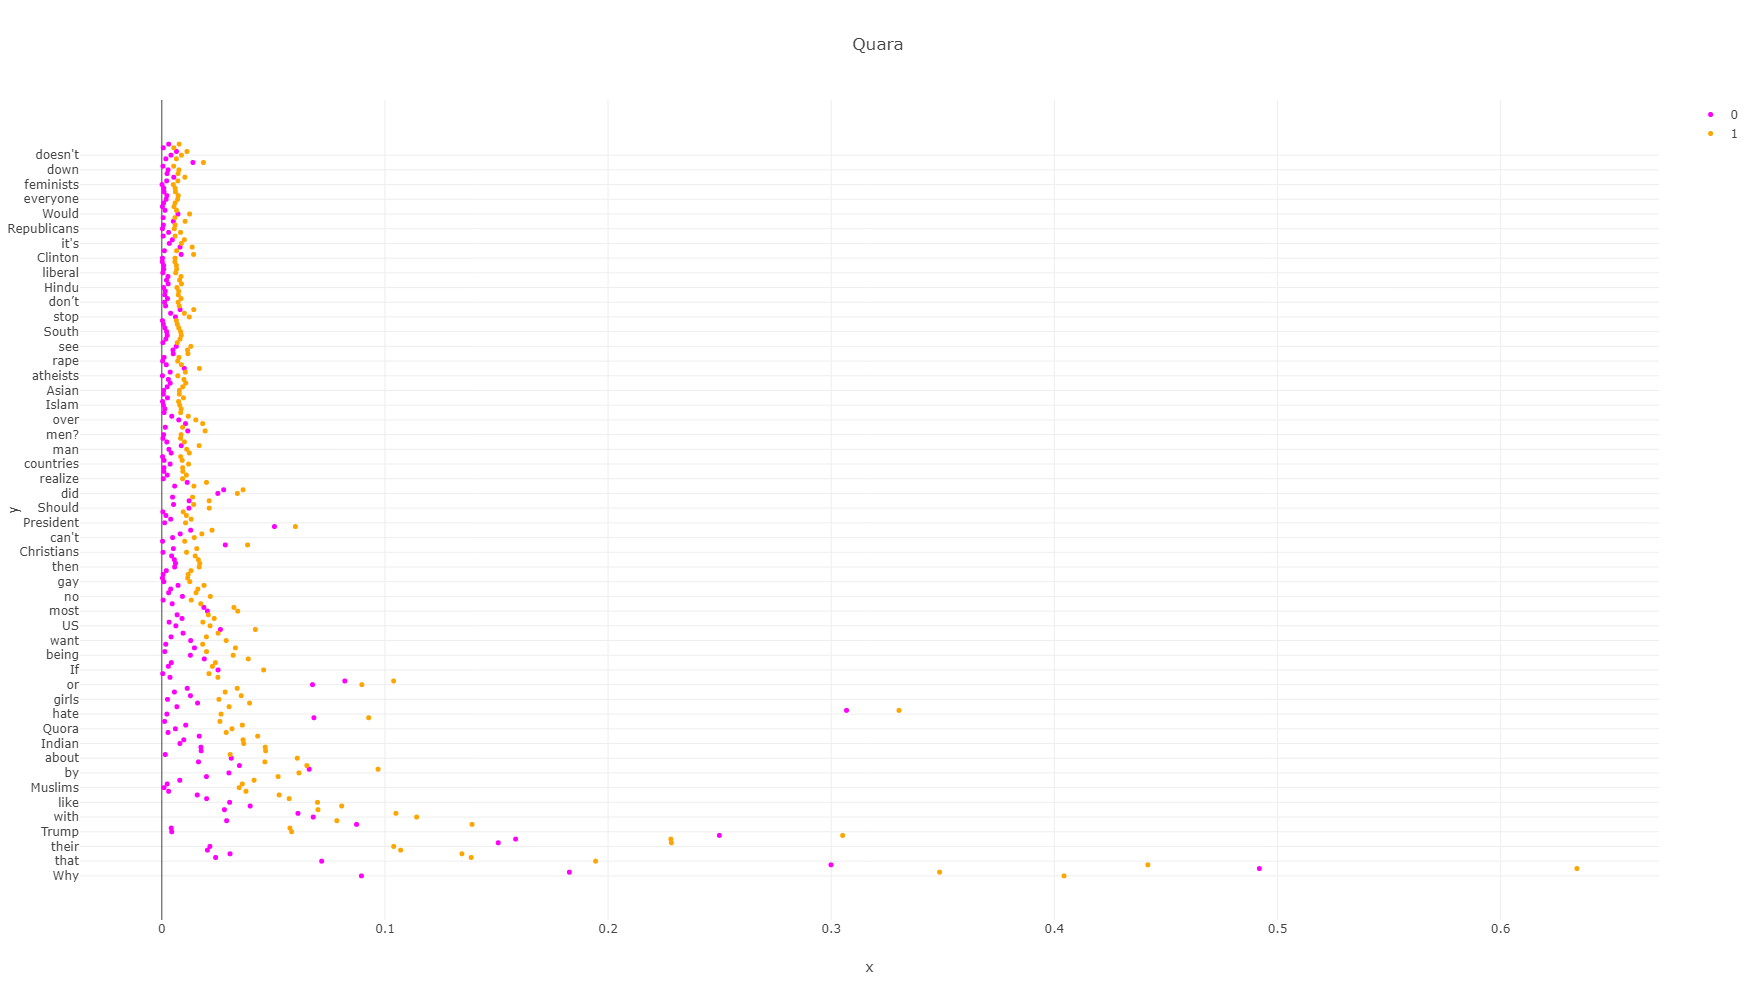

In [15]:
import plotly
import plotly.offline as offline
import plotly.graph_objs as go
plotly.offline.init_notebook_mode()


df.sort_values(by='diff', ascending=True, inplace=True)

#========================================================================
# Plotlyによる描画
#========================================================================
name = 'Quara'
title = 'Quara'
# trace = go.Line(
trace0 = go.Scatter(
    x = df['cnt_0'].iloc[:200],
    y = df['word'].iloc[:200],
    mode = "markers",
    marker = dict(size=5, color="rgb(255, 0, 255)"),
    name = '0'
)
trace1 = go.Scatter(
    x = df['cnt_1'].iloc[:200],
    y = df['word'].iloc[:200],
    mode = "markers",
    marker = dict(size=5, color="rgb(255, 165, 0)"),
    name = '1'
)

layout = go.Layout(
    title=title,
#     legend={"x":0.8, "y":0.1},
    autosize=False,
    width=500,
    height=1000,
    xaxis={"title":"x"},
    yaxis={"title":"y"},
    showlegend=True
#     yaxis2={"title":"Birth Rate", "overlaying":"y", "side":"right"},
)

data = [trace0, trace1]
fig = {'data':data, 'layout':layout}
offline.iplot(fig, filename='sin', image="png")